# Lab Session - Basic ML Concepts: Probability Distributions and Information Theory
---

In this lab session, we are going to consider various probability distributions, conditional probability and information theory.

__Note__: You can complete the lab entering code only in the  __# EXPECTED SPACE FOR STUDENT CODE__-blocks as well as the empty cells.

In [1]:
# Imports
# Can be installed through "pip install numpy scipy pandas matplotlib ipympl" or "pip install -r requirements.txt"
import time
from functools import partial
import numpy as np
from scipy.stats import norm #, beta as beta_dist, gamma as gamma_dist, poisson as poisson_dist, nbinom as nbinom_dist
from scipy.linalg import det, inv, pinv
from scipy.optimize import minimize
import pandas as pd # please make sure you have pandas installed (pip install pandas)
import math
import matplotlib.pyplot as plt  # please make sure you have matplotlib installed (pip install matplotlib)
from utils import plot_gaussian, show_images, show_marginals
from typing import List, Optional, Union, Tuple
from collections import Counter



# Exercise 1: Gaussian Distributions

We will start by considering the most prevalent distribution - the Gaussian. The Gaussian has several appealing properties that makes it easy to work with. In the following tasks, we will highlight some of these.

**Note:** For the following tasks, the purpose is to understand the properties of Gaussian distributions. As such, any readly-made distributions (scipy.stats.norm etc.) are disallowed. Using NumPy or SciPy for Linear Algebra is permitted.

Below, you see an implementation of a Gaussian distribution. We will use this highlight and implement properties that are typical of the Gaussian distribution. Please read through, and note the dunder (double under, \_\_methodname_\__) methods that are implemented. These allow us to add and subtract one Gaussian with another.

In [2]:
class GaussianDistribution:
    
    def __init__(self, mean, cov):
        """
        A Gaussian Distribution in arbitrary number of dimensions

        Args:
            mean (np.ndarray): Mean of the distribution.
            cov (np.ndarray): Covariance of the distribution.
        """
        self.mean = np.array(mean).reshape(1, -1)
        self.cov = np.array(cov)
        self.dims = self.mean.shape[1]
        
    def __str__(self):
        """
        Generates a string representation of the object, used for plotting
        and printing

        Returns:
            str: String representation of the object
        """        
        if self.dims == 2:
            string = f'Gaussian, Dim: {self.dims}    Mean: {self.mean}    Covariance: {self.cov[0, :]}{self.cov[1, :]}'
            
        else:
            string = f'Gaussian, Dim: {self.dims}    Mean: {np.round(self.mean[0, 0], 6)}    Covariance: {self.cov}'
        return string.replace('][', '     ').replace('[', '  ').replace(']', '  ')
        
    
    def __add__(self, other):
        """
        Adds two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean + other
            cov = self.cov
        
        else:
            mean = self.mean + other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)
              
    def __sub__(self, other):
        """
        Subtracts two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean - other
            cov = self.cov
            
        else:
            mean = self.mean - other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)  
           
    # sampling is a bit intricate - thus, we cheat a little bit here
    def sample(self, n_samples=1):
        """
        Samples from the distribution.

        Args:
            n_samples (int, optional): The number of samples to generate.
            Defaults to 1.

        Returns:
            np.ndarray: A numpy array of the sampled points.
        """        
        return norm(self.mean, self.cov).rvs(n_samples)
            
    # probability density function - general form
    def pdf(self, points):
        '''
        Evaluates the probability density function of the distribution.

        Args:
            points (np.ndarray): the points we want the probability density of,
            can come in either a list, np.array([dims]) or np.array([samples, dims])
            format
        
        Returns: 
            np.ndarray: A numpy array of probability densities
        '''

        points = np.array(points)
        if len(points.shape) == 1:
            points = points.reshape(1, -1)
            
        offset = points - self.mean
        if self.dims == 1:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(self.cov))
            exponent = np.exp(-0.5 * np.power(offset, 2) / self.cov)
            return norm_const * exponent
            
        else:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(det(self.cov)))
            exponent = np.exp(-0.5 * offset.dot((inv(self.cov)).dot(offset.T)))
            return np.diag(exponent * norm_const)
    
    
    def get_conditional(self, dim, value):
        '''
        Computes the conditional distribution on the remaining dimensions given
        the conditioned value in dimension dim.

        Args:
            dim: int - the dimension (assume only one) which we condition on
            value: float - the value of the conditioned dimension
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
            
        # EXPECTED SPACE FOR STUDENT CODE - START
        
        # some hints to help:
        
        non_cond_dims = np.arange(self.dims) != dim
        cond_dims = np.arange(self.dims) == dim

        cov_xy = self.cov[non_cond_dims, cond_dims][np.newaxis, :]
        # block means
        mu_x = self.mean[0, non_cond_dims].reshape(-1, 1)   # (Dx,1)
        mu_y = self.mean[0, cond_dims].reshape(-1, 1)       # (1,1)

        # block covariances
        Sigma_xx = self.cov[np.ix_(non_cond_dims, non_cond_dims)]  # (Dx,Dx)
        Sigma_xy = self.cov[np.ix_(non_cond_dims, cond_dims)]      # (Dx,1)
        Sigma_yx = self.cov[np.ix_(cond_dims, non_cond_dims)]      # (1,Dx)
        Sigma_yy = self.cov[np.ix_(cond_dims, cond_dims)]          # (1,1)

        # scalar inverse (或用 np.linalg.pinv 更稳健)
        inv_Sigma_yy = 1.0 / Sigma_yy

        y = np.array([[value]])  # (1,1)

        conditional_mean = (mu_x + Sigma_xy @ inv_Sigma_yy @ (y - mu_y)).T  # 变回 shape (1,Dx)
        conditional_cov  = Sigma_xx - Sigma_xy @ inv_Sigma_yy @ Sigma_yx
        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(conditional_mean, conditional_cov)

    def marginalize(self, dim):
        '''
        Computes the marginal distribution on the remaining dimensions when having
        marginalized out dimension dim.
        
        Args:
            dim: int - the dimension (assume only one) which we marginalize
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
            
        # EXPECTED SPACE FOR STUDENT CODE - START
        # 哪些维度保留（非边缘化）
        non_marg_dims = np.arange(self.dims) != dim

        # 边缘化后的均值和协方差
        marginal_mean = self.mean[0, non_marg_dims].reshape(1, -1)
        marginal_cov  = self.cov[np.ix_(non_marg_dims, non_marg_dims)]
        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(marginal_mean, marginal_cov)


### Exercise 1.1
We first want to demonstrate how a Gaussian looks and how it is expected to behave - particularly its linear properties. __Throughout this task, we assume that the random variables we work with are independent of one another__ (e.g. __A__ is independent of __B__). Create four Gaussians:

__A__: $\mu = 1, \sigma^2 = 2$

__B__: $\mu = -2, \sigma^2 = 0.1$

__C__: $\mu = \begin{bmatrix}
1 & 0
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & 0.9\\
0.9 & 2
\end{bmatrix}$

__D__: $\mu = \begin{bmatrix}
-1 & 2
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & -0.7\\
-0.7 & 1
\end{bmatrix}$

Visualize, through the provided plotting function below, _plot_gaussian_:

a. __A__

b. __B__

c. __A__ + __B__

d. __C__

e. __D__

f. __C__ - __D__

__Questions__:

1. What is meant by "The Gaussian distribution is fully characterized by its mean and covariance"?
2. If two Gaussians are added, can the (co-)variance ever decrease?

__Answers__:

1. mean value desides the position(center/spike);
covariance decides the width/ orientation, major axis and minor axis of the ellipse.
2. No. (co-)variance matrix is PSD (PSD, Positive Semi-Definite), the sum is also PSD.

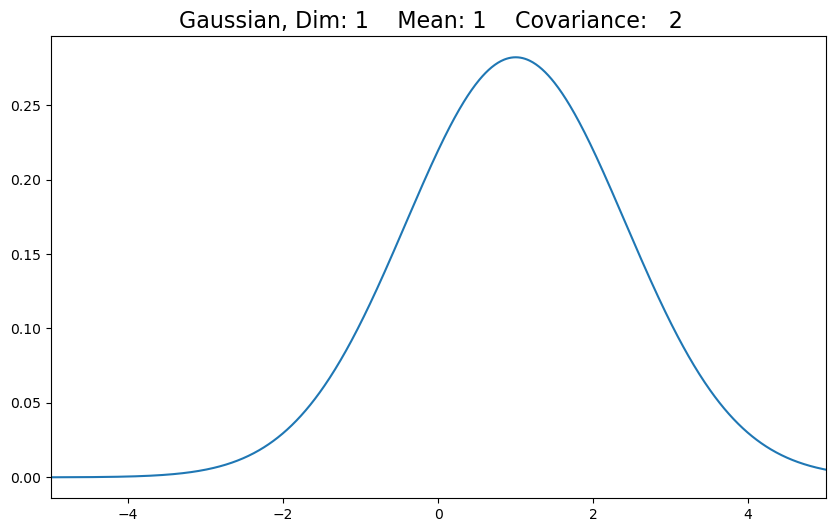

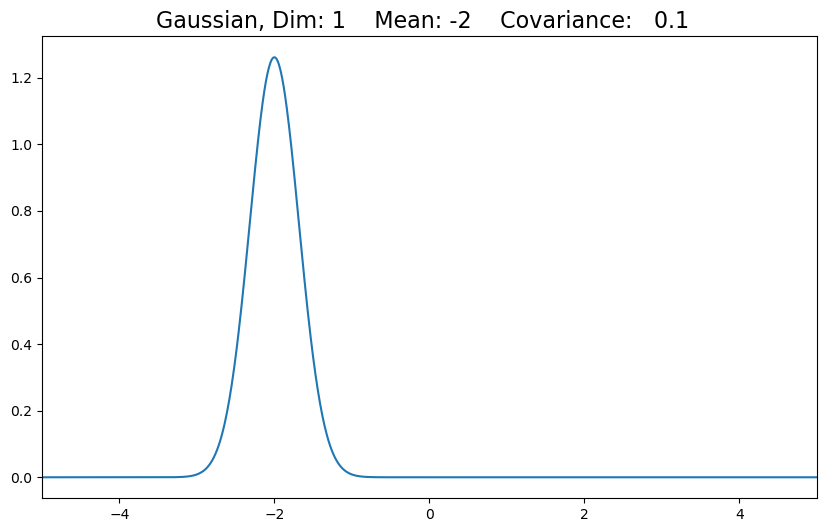

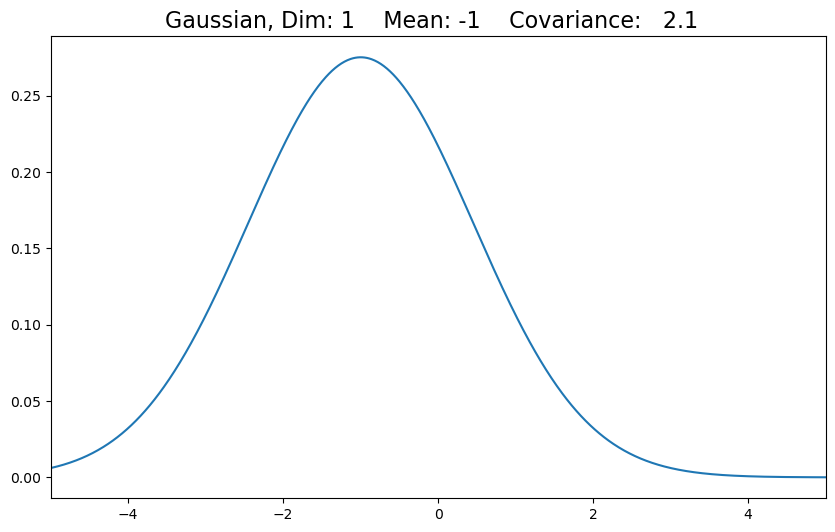

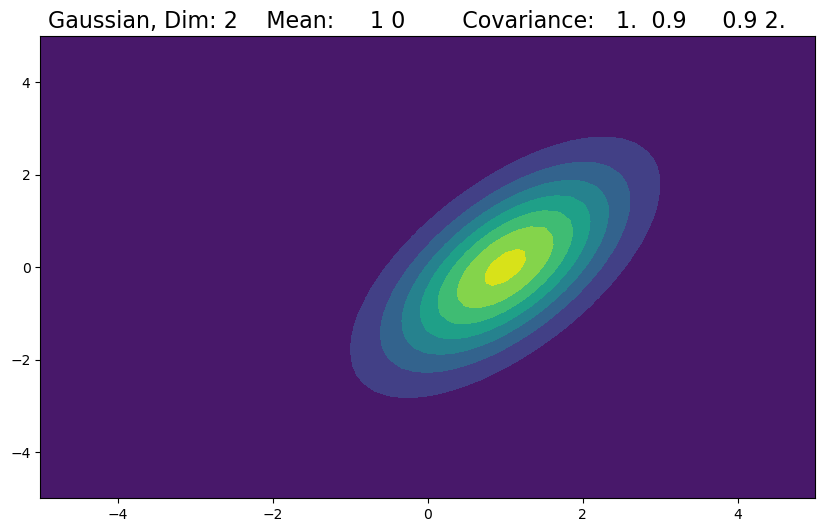

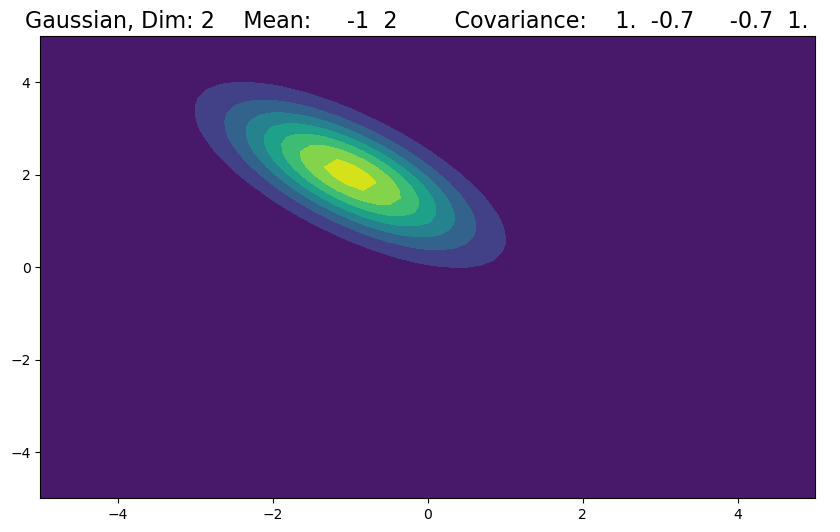

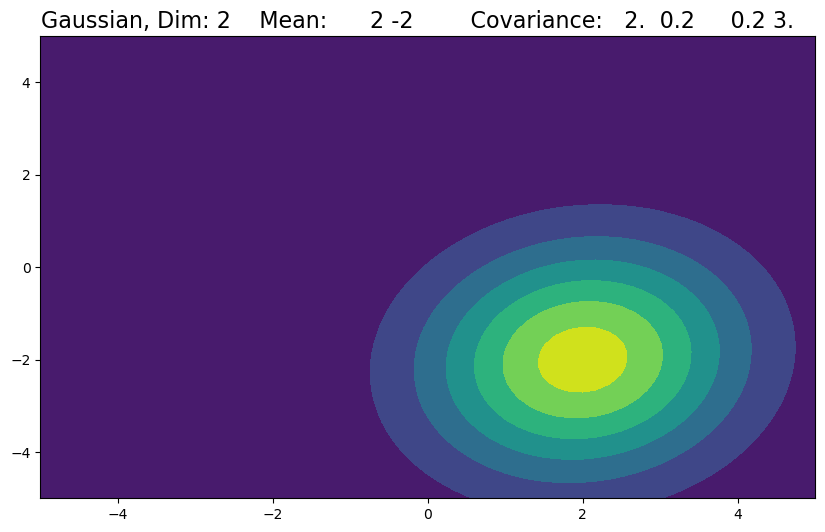

In [ ]:
# EXPECTED SPACE FOR STUDENT CODE - START
gaussian_A = GaussianDistribution(mean=np.array([1]), cov=np.array([2]))
gaussian_B = GaussianDistribution(mean=np.array([-2]), cov=np.array([0.1]))
gaussian_C = GaussianDistribution(
    mean=np.array([1, 0]),
    cov=np.array([[1, 0.9],
                  [0.9, 2]])
)

gaussian_D = GaussianDistribution(
    mean=np.array([-1, 2]),
    cov=np.array([[1, -0.7],
                  [-0.7, 1]])
)
#visualize
#a
plot_gaussian(gaussian_A)
#b
plot_gaussian(gaussian_B)
#c
gaussian_sum_AB = gaussian_A + gaussian_B
plot_gaussian(gaussian_sum_AB)
#d
plot_gaussian(gaussian_C)
#e
plot_gaussian(gaussian_D)
#f
gaussian_sub_CD = gaussian_C - gaussian_D
plot_gaussian(gaussian_sub_CD)
# EXPECTED SPACE FOR STUDENT CODE - END

### Exercise 1.2
__Task__: Implement the `marginalize` function of the class GaussianDistribution. Test, for __C__, that your resulting Gaussian looks like the one in the plot. Plot the resulting distribution for __C__ when marginalizing on $y$, and on __D__ when marginalizing on $x$.

__Question__: What does one effectively do when marginalizing a variable of a distribution?

__Answer__:  integrate over that variable so you drop it from the joint distribution—what remains is the distribution over the other variables.


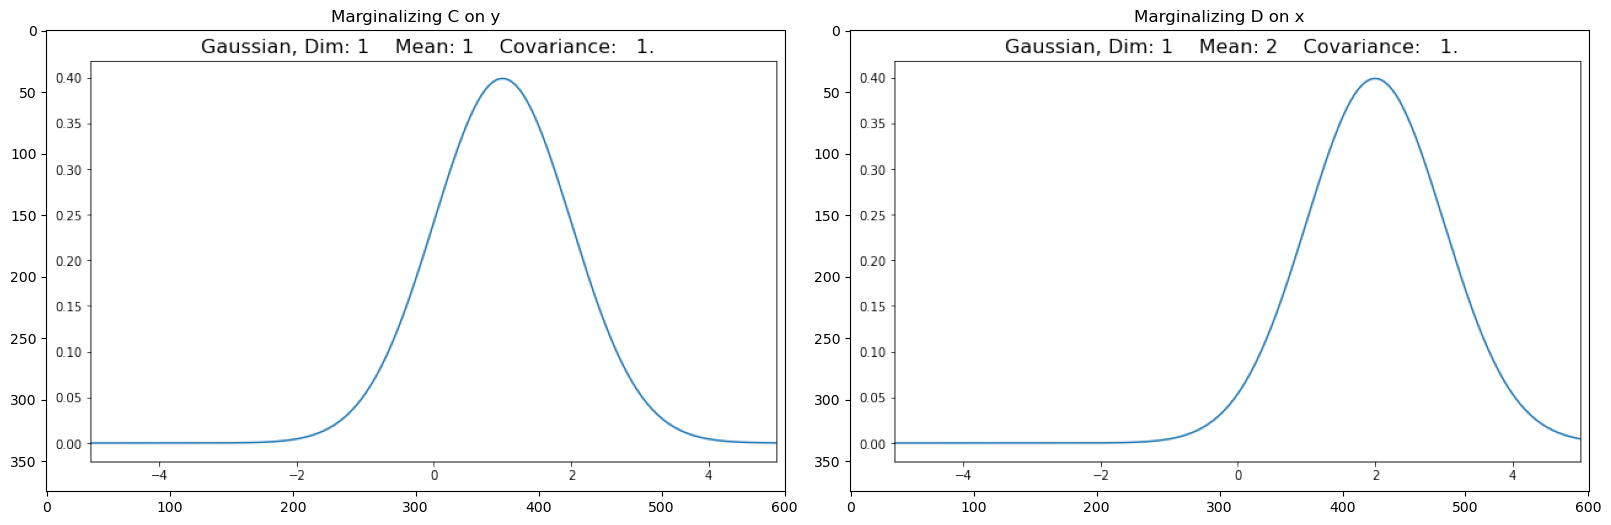

In [4]:
show_marginals()

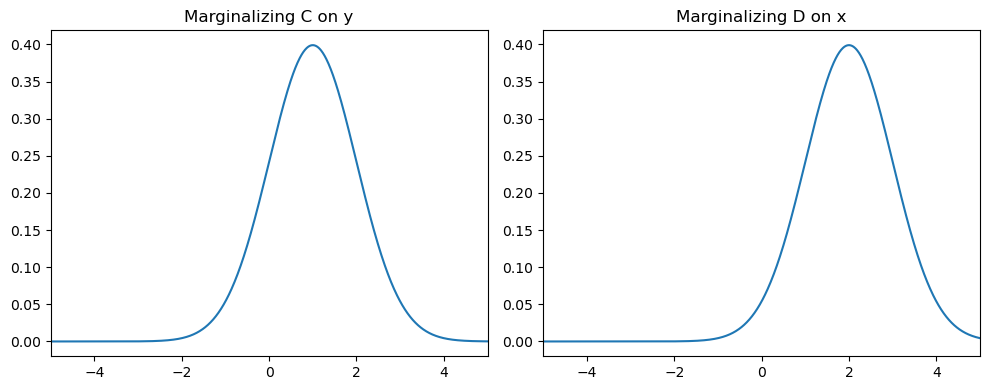

In [15]:
# Some code to test if you've marginalized distribution C correctly
 #marg_C = gaussian_C.marginalize(dim=1)

 #plot_gaussian(marg_C)
from utils import plot_onedim

marginal_C_y = gaussian_C.marginalize(dim=1)
marginal_D_x = gaussian_D.marginalize(dim=0)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_onedim(axes[0], marginal_C_y)
axes[0].set_title('Marginalizing C on y')
plot_onedim(axes[1], marginal_D_x)
axes[1].set_title('Marginalizing D on x')
plt.tight_layout()

### Exercise 1.3
__Task__: Implement the `get_conditional` function of the class GaussianDistribution. Test, for the Gaussians __C__ and __D__ from 1.1, that your resulting conditional looks like the ones in the plots, when conditioning on $x=2$ and $y=4$, respectively. 

__Hint 1__: Use the numpy arrays to retrieve the right dimensions when performing the computation (`cond_dims` are the dimensions we condition on, `non_cond_dims` are the non-conditioned dimensions). Example:

$\Sigma_{yx} = $ `self.cov[cond_dims, non_cond_dims][:, np.newaxis]`

__Hint 2__: Use either np.matmul, np.dot or the @ operator to perform matrix matrix multiplications.

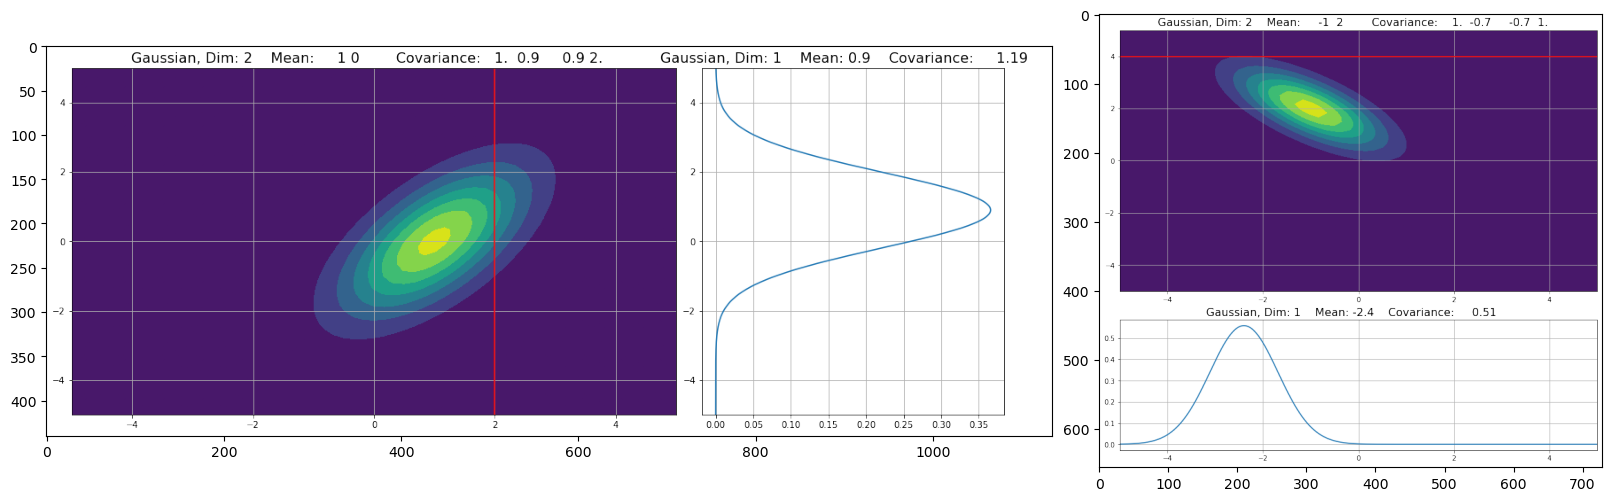

In [18]:
show_images()

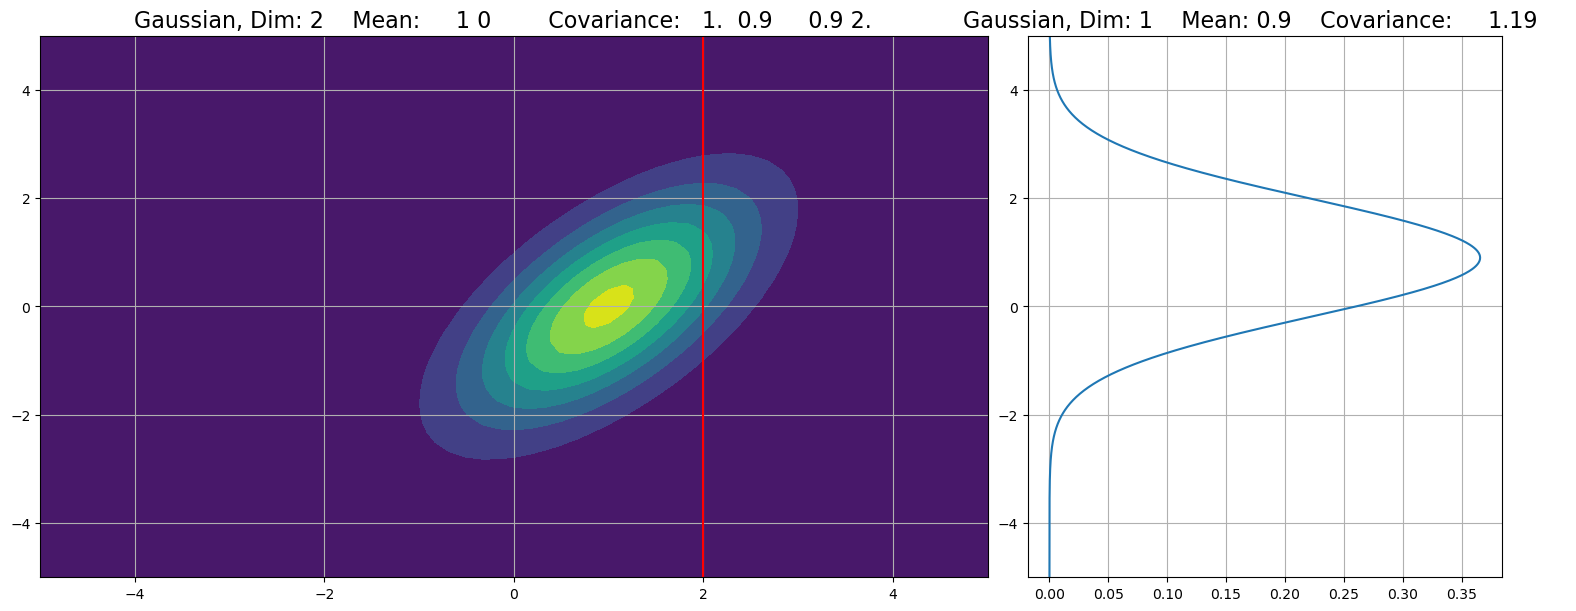

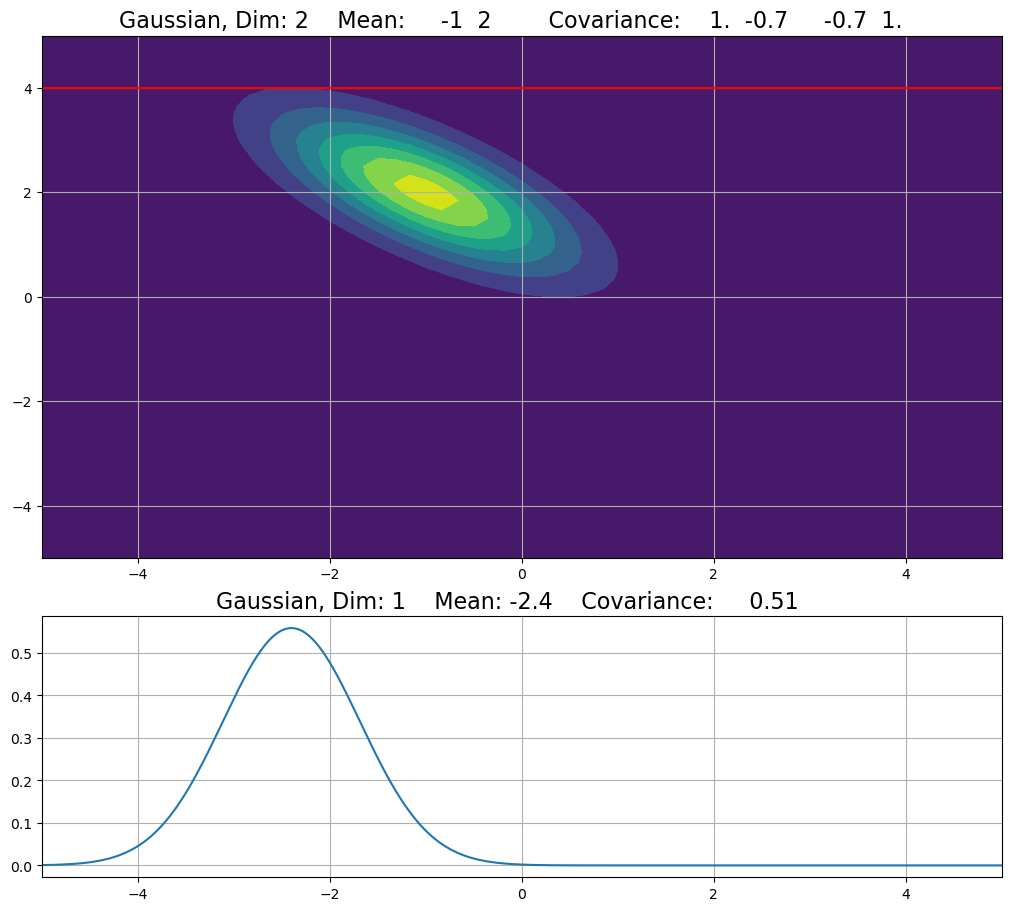

In [22]:
# Test that this produces the same plot (including the colors, which indicates the computed pdf)
# gaussian_C = GaussianDistribution(mean=np.array([1, 0]), cov=np.array([[1, 0.9], [0.9, 2]]))

# Use these lines to compute the conditionals
conditional_C = gaussian_C.get_conditional(dim=0, value=2)

# Use these lines to generate the plots - plots both the initial distribution and the conditional along the right axis
plot_gaussian(gaussian_C, conditional_dist=conditional_C, condition_axis=0, condition_value=2)

conditional_D = gaussian_D.get_conditional(dim=1, value=4)
plot_gaussian(gaussian_D, conditional_dist=conditional_D, condition_axis=1, condition_value=4)

# Exercise 2: Information Theory

Here, we will work with entropy, information gain and mutual information.

### Exercise 2.1
In this exercise we are going to work with characters in an alphabet.
Assume, you have a string 'cdd', then the frequencies of 'c' and 'd' are $ p(^\prime{}c^\prime{})=\frac{1}{3} $ and $ p(^\prime{}d^\prime{})=\frac{2}{3} $.
We can interpret $ p $ as a probability distribution over an alphabet.

Assume you only have two characters in an alphabet, 'a' and 'b'. 


* **What does the probability of 'a' and 'b' have to be in order for the entropy to be maximal?**
* **What is the maximum value of the entropy in this case?**
* **Intuitively, why is the entropy maximum for the value you found?** (You can calculate it on paper or write it in Python, you will need it later anyway)

***Your answers:***
1. p(a)=p(b)=0.5
2. $$H = -0.5\log_2 0.5 - 0.5\log_2 0.5 = 1$$
3. Because entropy measures uncertainty. When p(a)=p(b), each character has an equal probability of appearing, with no bias, making it the most difficult to predict.

In [23]:
import math

ps = [i / 100 for i in range(101)]

def entropy(p):
    if p in (0, 1):
        return 0
    return -(p * math.log2(p) + (1 - p) * math.log2(1 - p))

entropies = [(p, entropy(p)) for p in ps]
max_p, max_entropy = max(entropies, key=lambda x: x[1])
print(f'max entropy {max_entropy:.6f} at p(a)={max_p}')


max entropy 1.000000 at p(a)=0.5


### Exercise 2.2

Still assume that your alphabet consists of only two characters, 'a' and 'b'.
For values $ p(^\prime{}a^\prime{}) = 0.01, 0.02, \ldots, 0.99 $, plot the entropy of your alphabet ($ x $-axis: $ p(^\prime{}a^\prime{}) $, $ y $-axis: Entropy in bits).
Your plot should contain only one line.

If you don't know how to plot with Matplotlib, there is a really short crash course in the next cell.

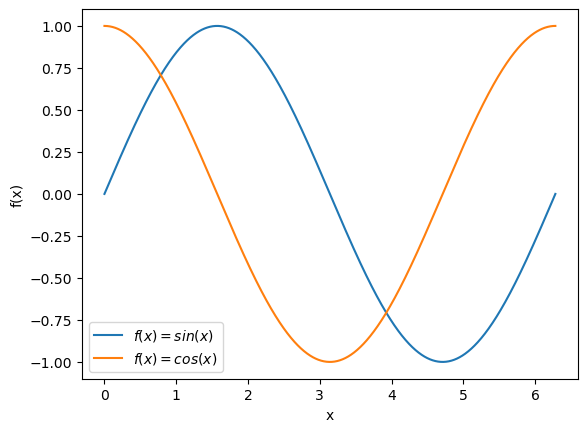

In [24]:
x = np.linspace(0, 2 * math.pi, 1000)  # generate 1000 x-values between 0 (inclusive) and 2 pi (inclusive)
y1 = np.sin(x)  # compute sine of x elementwise
y2 = np.cos(x)  # compute sine of x elementwise
plt.plot(x, y1, label=r"$f(x)=sin(x)$")  # plot values with label
plt.plot(x, y2, label=r"$f(x)=cos(x)$")  # plot values with label
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()  # show legend
# you might need to run plt.show() if nothing shows up

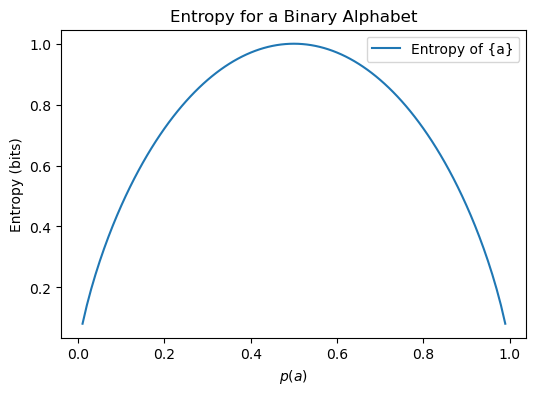

In [25]:
# ******************
# * Your code here *
# ******************
import math
import matplotlib.pyplot as plt

p_values = [i / 100 for i in range(1, 100)]  # 0.01 - 0.99
entropies = [
    -(p * math.log2(p) + (1 - p) * math.log2(1 - p))
    for p in p_values
]

plt.figure(figsize=(6, 4))
plt.plot(p_values, entropies, label='Entropy of {a}')
plt.xlabel(r'$p(a)$')
plt.ylabel('Entropy (bits)')
plt.title('Entropy for a Binary Alphabet')
plt.legend()
plt.show()


### Exercise 2.3
A measure that is related to Entropy is the *Gini Impurity* which is defined as
$$
    G(p) = 1-\sum_{x\in\mathcal{X}}p(x)^2
$$

Both entropy and Gini impurity are used in decision tree learning to measure the ``level of disorderliness''. In the following, we want to discover similarities and differences.

Extend the plot from Exercise 2.2, such that you also plot the Gini Impurity for the different values of $ p(^\prime{} a^\prime{}) $. **What do you notice?**

1. Both measures peak at p(a)=0.5, reflecting maximal disorder when the alphabet is uniform.
2. Gini forms a smooth parabola while entropy rises and falls more sharply.

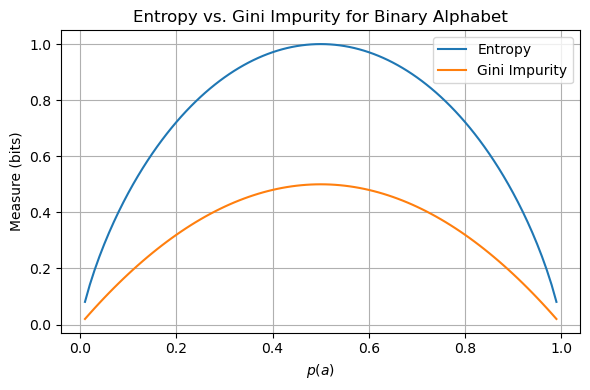

In [26]:
# ******************
# * Your code here *
# ******************
import math
import matplotlib.pyplot as plt

p_values = [i / 100 for i in range(1, 100)]
entropies = [
    -(p * math.log2(p) + (1 - p) * math.log2(1 - p))
    for p in p_values
]
ginis = [1 - p ** 2 - (1 - p) ** 2 for p in p_values]

plt.figure(figsize=(6, 4))
plt.plot(p_values, entropies, label='Entropy', color='tab:blue')
plt.plot(p_values, ginis, label='Gini Impurity', color='tab:orange')
plt.xlabel(r'$p(a)$')
plt.ylabel('Measure (bits)')
plt.title('Entropy vs. Gini Impurity for Binary Alphabet')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now we extend our comparison to three dimensions. We have three variables $ x_1 $, $ x_2 $, and $ x_3 $ and plot their entropies and Gini impurities.
The $ x $- and $ y $-axes show the values $ p(x_1) $ and $ p(x_2) $, respectively. The value $ p(x_3) $ is implicitly defined as $ 1-p(x_2)-p(x_1) $.
We also plot the point of maximum entropy / gini impurity. 

**What do you notice? If you have $ n $ instead of three random variables, what are the bounds for the entropy and the Gini impurity?**

Entropy and Gini reach their maximum values at uniform distributions and decrease as a component becomes increasingly biased toward 0 or 1 

The entropy H over n categories ranges from 0 up to log₂ n, with the maximum attained when the distribution is uniform (each category has probability 1/n).

Gini impurity varies between 0 and 1−1/n, and it also peaks at the uniform distribution.

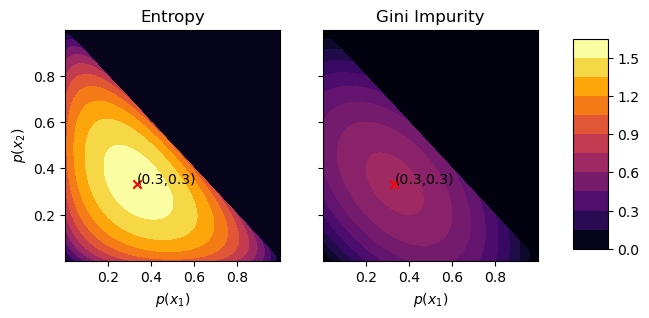

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
resolution = 501
x = np.linspace(1e-8, 1 - 1e-8, resolution)
y = np.linspace(1e-8, 1 - 1e-8, resolution)
xx, yy = np.meshgrid(x, y)


def entropy(x, y):
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    z = 1 - x - y
    res = x * np.log2(x) + y * np.log2(y) + z * np.log2(z)
    res[np.isnan(res)] = 0
    # we didn't ensure that z isn't negative above, so we manually set nan values to 0 here
    
    return -res


def gini_impurity(x, y):
    z = 1 - x - y
    gin = 1 - x ** 2 - y ** 2 - z ** 2
    # we work with probabilities so we only consider the cases where x+y+z = 1 *AND* x >=0, y>=0, z>=0
    # but you can actually see something interesting if you remove this (other than for the entropy)
    gin[z < 0] = 0
    return gin


ims = []
for _ax, measure, label in zip(ax, [entropy, gini_impurity], ['Entropy', 'Gini Impurity']):
    values = measure(xx, yy)
    im = _ax.contourf(xx, yy, values, levels=10, vmin=0, vmax=np.log2(3), cmap='inferno')
    ims.append(im)
    max_idx = np.unravel_index(np.argmax(values, axis=None), values.shape)
    _ax.text(max_idx[0] / resolution,
             max_idx[1] / resolution,
             f"({max_idx[0] / resolution:.1f},{max_idx[1] / resolution:.1f})")
    _ax.scatter(max_idx[0] / resolution, max_idx[1] / resolution, marker='x', color='r')
    _ax.set_title(label)
    _ax.set_xlabel(f'$p(x_1)$')
ax[0].set_ylabel(r'$p(x_2)$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ims[0], cax=cbar_ax)

# Exercise 3

In the next exercise, we will work with joint probability distributions. For this purpose, we use the Kaggle Titanic dataset which consists of records of survivors and non-survivors of the Titanic disaster. For this exercise, we will be only interested in some of the attributes, `Survived` and `Sex`.

In [29]:
titanic = pd.read_csv("titanic.csv")
titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


For example, we can find the male passengers as follows

In [30]:
titanic.query("Sex == 'male'")

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
6,0,1,Mr. Timothy J McCarthy,male,54.0,0,0,51.8625
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
...,...,...,...,...,...,...,...,...
879,0,2,Mr. Frederick James Banfield,male,28.0,0,0,10.5000
880,0,3,Mr. Henry Jr Sutehall,male,25.0,0,0,7.0500
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


and we can find the number male passengers by

In [31]:
len(titanic.query("Sex == 'male'"))

573

Similarly, we can filter by multiple attributes, for example, to find all male passenger in the third class

In [32]:
titanic.query("Sex == 'male' and Pclass == 3")

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
12,0,3,Mr. William Henry Saundercock,male,20.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
873,0,3,Mr. Nedelio Petroff,male,19.0,0,0,7.8958
874,0,3,Mr. Kristo Laleff,male,23.0,0,0,7.8958
877,0,3,Mr. Johann Markun,male,33.0,0,0,7.8958
880,0,3,Mr. Henry Jr Sutehall,male,25.0,0,0,7.0500


We can select only the passenger names by

In [33]:
titanic['Name']

0                                 Mr. Owen Harris Braund
1      Mrs. John Bradley (Florence Briggs Thayer) Cum...
2                                  Miss. Laina Heikkinen
3            Mrs. Jacques Heath (Lily May Peel) Futrelle
4                                Mr. William Henry Allen
                             ...                        
882                                 Rev. Juozas Montvila
883                          Miss. Margaret Edith Graham
884                       Miss. Catherine Helen Johnston
885                                 Mr. Karl Howell Behr
886                                   Mr. Patrick Dooley
Name: Name, Length: 887, dtype: object

### Exercise 3.1

***Fill in the following table.*** 

The random variable $ S $ describes a passenger's sex, the variable $ V $ whether they survived or not.


| $ S $ / $ V $ | dead | alive | P($ S $) |
| --------- | ---- | ----- | ------ |
| **female** | 81 | 233 | 314/887≈0.354 |
| **male** | 464 | 109 | 573 / 887 ≈ 0.646 |
| **P($ V $)** | 545/887≈0.614 | 342/887≈0.386 | 1 |

In [40]:
titanic.query("Sex == 'female' and Survived == 0")

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
14,0,3,Miss. Hulda Amanda Adolfina Vestrom,female,14.0,0,0,7.8542
18,0,3,Mrs. Julius (Emelia Maria Vandemoortele) Vande...,female,31.0,1,0,18.0000
24,0,3,Miss. Torborg Danira Palsson,female,8.0,3,1,21.0750
38,0,3,Miss. Augusta Maria Vander Planke,female,18.0,2,0,18.0000
40,0,3,Mrs. Johan (Johanna Persdotter Larsson) Ahlin,female,40.0,1,0,9.4750
...,...,...,...,...,...,...,...,...
850,0,2,Mrs. Ernest Courtenay (Lilian Hughes) Carter,female,44.0,1,0,26.0000
859,0,3,Miss. Dorothy Edith Sage,female,14.0,8,2,69.5500
878,0,3,Miss. Gerda Ulrika Dahlberg,female,22.0,0,0,10.5167
881,0,3,Mrs. William (Margaret Norton) Rice,female,39.0,0,5,29.1250


In [41]:
len(titanic.query("Sex == 'female' and Survived == 0"))

81

In [42]:

titanic.query("Sex == 'female' and Survived == 1")

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
8,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27.0,0,2,11.1333
9,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14.0,1,0,30.0708
...,...,...,...,...,...,...,...,...
870,1,2,Mrs. Samuel (Hannah Wizosky) Abelson,female,28.0,1,0,24.0000
871,1,3,Miss. Adele Kiamie Najib,female,15.0,0,0,7.2250
875,1,1,Mrs. Thomas Jr (Lily Alexenia Wilson) Potter,female,56.0,0,1,83.1583
876,1,2,Mrs. William (Imanita Parrish Hall) Shelley,female,25.0,0,1,26.0000


In [43]:
len(titanic.query("Sex == 'female' and Survived == 1"))

233

In [44]:
titanic.query("Sex == 'male' and Survived == 0")

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
6,0,1,Mr. Timothy J McCarthy,male,54.0,0,0,51.8625
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
...,...,...,...,...,...,...,...,...
877,0,3,Mr. Johann Markun,male,33.0,0,0,7.8958
879,0,2,Mr. Frederick James Banfield,male,28.0,0,0,10.5000
880,0,3,Mr. Henry Jr Sutehall,male,25.0,0,0,7.0500
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000


In [45]:
len(titanic.query("Sex == 'male' and Survived == 0"))

464

In [46]:
titanic.query("Sex == 'male' and Survived == 1")

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
17,1,2,Mr. Charles Eugene Williams,male,23.0,0,0,13.0000
21,1,2,Mr. Lawrence Beesley,male,34.0,0,0,13.0000
23,1,1,Mr. William Thompson Sloper,male,28.0,0,0,35.5000
36,1,3,Mr. Hanna Mamee,male,18.0,0,0,7.2292
54,1,1,Mr. Hugh Woolner,male,46.0,0,0,35.5000
...,...,...,...,...,...,...,...,...
834,1,3,Mr. Chang Chip,male,32.0,0,0,56.4958
835,1,1,Mr. Pierre Marechal,male,29.0,0,0,29.7000
853,1,1,Mr. Peter Denis Daly,male,51.0,0,0,26.5500
865,1,3,Master. Harold Theodor Johnson,male,4.0,1,1,11.1333


In [47]:
len(titanic.query("Sex == 'male' and Survived == 1"))

109

### Exercise 3.2

* **Find the value $ H(S) $. Is this a high or a low entropy? For what distribution would the uncertainty be maximal/minimal (with which value)?**

When p=0.5, the uncertainty reach maximal.
When p=0、p=1, the uncertainty reach minimal.

Sex probabilities:
 Sex
male      0.645998
female    0.354002
Name: proportion, dtype: float64
H(S) = 0.937592 bits


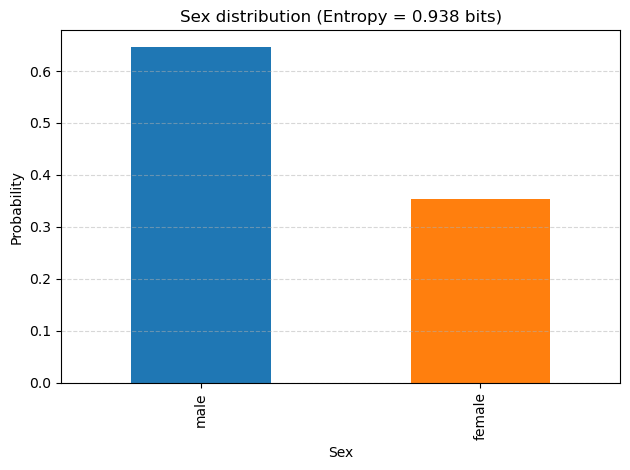

In [50]:
# *****************
# *** Your code ***
# *****************
sex_probs = titanic["Sex"].value_counts(normalize=True)

entropy = -(sex_probs * np.log2(sex_probs)).sum()

print("Sex probabilities:\n", sex_probs)
print(f"H(S) = {entropy:.6f} bits")

sex_probs.plot(kind="bar", color=["tab:blue", "tab:orange"])
plt.ylabel("Probability")
plt.title(f"Sex distribution (Entropy = {entropy:.3f} bits)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



### Exercise 3.3

It is commonly said that the class you traveled in affected your survival chances. Let's test this.

* **Calculate $ H(V) $, $ H(V|C) $, and $ MI(V; C) $** where $ C $ is an RV for the class ('Pclass' in the dataset). Does knowing the class you traveled in reduce your uncertainty about whether a passenger died?

In [52]:
# *****************
# *** Your code ***
# *****************
# H(V)-Uncertainty Regarding Death/Survival
p_V = titanic["Survived"].value_counts(normalize=True)
H_V = -(p_V * np.log2(p_V)).sum()

# H(V|C)-how much uncertainty remains in V when carrying class information.
grouped = titanic.groupby("Pclass")["Survived"].value_counts(normalize=True)
H_V_given_C = 0
for cls in titanic["Pclass"].sort_values().unique():
    p_c = (titanic["Pclass"] == cls).mean()
    p_cond = grouped.loc[cls]
    H_c = -(p_cond * np.log2(p_cond)).sum()
    H_V_given_C += p_c * H_c
#MI_VC-Measures the reduction in uncertainty about survival V after knowing compartment C.
MI_VC = H_V - H_V_given_C

print(f"H(V) = {H_V:.6f} bits")
print(f"H(V|C) = {H_V_given_C:.6f} bits")
print(f"MI(V;C) = {MI_VC:.6f} bits")

H(V) = 0.961881 bits
H(V|C) = 0.879017 bits
MI(V;C) = 0.082864 bits


### Exercise 3.4

Now do the same for $ H(V|S) $ and $ MI(V; S) $.

* **Which does help you more in deciding whether a passenger died or not, knowing their sex or travel class?**

Knowing sex.

In [53]:
# *****************
# *** Your code ***
# *****************
# H(V)-Uncertainty Regarding Death/Survival
p_V = titanic["Survived"].value_counts(normalize=True)
H_V = -(p_V * np.log2(p_V)).sum()

# H(V|S)-how much uncertainty remains in V when carrying sex information.
grouped_s = titanic.groupby("Sex")["Survived"].value_counts(normalize=True)
H_V_given_S = 0
for sex in titanic["Sex"].sort_values().unique():
    p_s = (titanic["Sex"] == sex).mean()
    p_cond = grouped_s.loc[sex]
    H_s = -(p_cond * np.log2(p_cond)).sum()
    H_V_given_S += p_s * H_s
#MI_VS-Measures the reduction in uncertainty about survival V after knowing compartment C.
MI_VS = H_V - H_V_given_S

print(f"H(V) = {H_V:.6f} bits")
print(f"H(V|S) = {H_V_given_S:.6f} bits")
print(f"MI(V;S) = {MI_VS:.6f} bits")

H(V) = 0.961881 bits
H(V|S) = 0.745031 bits
MI(V;S) = 0.216850 bits


# Exercise 4 - MLE, Overfitting and Cross-validation
Here, we are going to look at a synthetic regression problem, and how under- and overfitting can occur through better or worse model parameterizations. We will also look at the most common mean of evaluating model performance, namely cross-validation. We'll consider learning the function below through polynomial regression on a number of given data points:

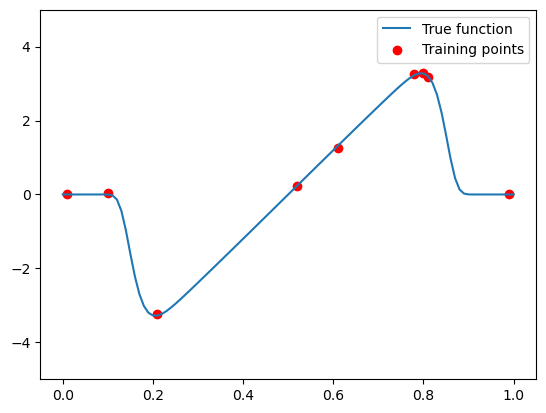

In [54]:
def true_function(X):
    return 12 * np.exp(-1e6 * np.power(1.2 * (X - 0.5), 16)) * np.sin((X - 0.5))

def noisy_function(X):
    return true_function(X) + np.random.randn(X.size) * 0.04

eval_points = np.array([0.01, 0.1, 0.21, 0.52, 0.61, 0.78, 0.80, 0.81, 0.99])
X_plot = np.linspace(0, 1, 101)

fig3, ax3 = plt.subplots()
ax3.plot(X_plot, true_function(X_plot), label='True function')
ax3.scatter(eval_points, noisy_function(eval_points), c='r', label='Training points')
ax3.legend()
ax3.set_ylim(-5, 5)
plt.show()

### Exercise 4.1
Look at the class `PolynomialRegression` (a type of Generalized Linear Model) and pay attention to its attributes and _predict_ method. This class is intended to fit a polynomial of a given degree to the data points, by calling some method to fit the data points.

__Task__: Implement the closed-form Maximum Likelihood parameter estimation in the `fit_MLE` method. The closed-form expression for the optimal parameters can be found in the Lecture 3 on the section on Maximum Likelihood. Ensure it works by fitting a polynomial of degree 10 to the data points - it should fit most data points reasonably well.

__Hint__: Keep in mind that a polynomial of degree 2 has 3 coefficients.

$\theta = (\Phi^\top \Phi)^{-1} \Phi^\top y$

In [55]:
class PolynomialRegression:
    
    def __init__(self, degree):
        """
        A Polynomial Regression model of a given degree,

        Args:
            degree (int): The degree of the polynomial regression.
        """        
        self.degree = degree
        self.weights = None
        
    def fit_MLE(self, X, y):
        """
        Fits the weights of the model according to the Maximum Likelihood.

        Args:
            X ([type]): The explanatory variables of the data.
            y ([type]): The dependent variables of the data.
        """
        # EXPECTED SPACE FOR STUDENT CODE - START

        X = np.array(X)
        y = np.array(y)
        phi = np.power(X[:, np.newaxis], np.arange(self.degree + 1))
        self.weights = np.linalg.pinv(phi).dot(y)

        # EXPECTED SPACE FOR STUDENT CODE - END
    
    
    def predict(self, X):
        """
        Predicts the output value(s) of a fitted model on the data point(s) X,

        Args:
            X ([type]): The explanatory variables of the data point(s) that is to 
            be predicted..

        Raises:
            ValueError: If no model is fitted (self.weights are None), no prediction
            can be made and an error is raised.

        Returns:
            np.ndarray: The predicted output value of the data point(s) X.
        """        

        if self.weights is None:
            raise ValueError('Need to fit the model before predicting!')

        theta = np.power(X[:, np.newaxis], np.arange(self.degree+1))
        preds = theta.dot(self.weights)
        return preds
            
    def print_weights(self):
        """
        Prints the weights of the model in a structured format.
        """        
        for i in range(self.degree):
            print('Coeff. theta^{}:   {:.2f}'.format(i, self.weights[i]))


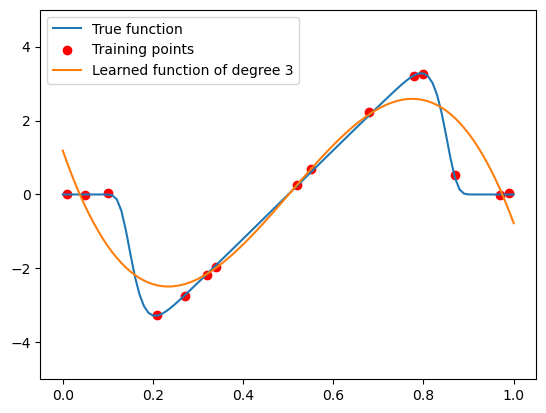

In [56]:
polynomial_degree = 3

pr = PolynomialRegression(polynomial_degree)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52, 0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
pr.fit_MLE(X_eval, y_eval)

# Plotting
X_plot = np.linspace(-0.0, 1.0, 101)
fig3_1, ax3_1 = plt.subplots()
ax3_1.plot(X_plot, true_function(X_plot), label='True function')

ax3_1.scatter(X_eval, y_eval, c='r', label='Training points')
ax3_1.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_1.set_ylim(-5, 5)
ax3_1.legend()
plt.show()

### Exercise 4.2
We will now discover what happens if we under- and overfit parameters, as well as how additional data helps counteract overfitting. 

__Task__: Toy around with the fit of the generalized linear model below to find degrees where it under- and overfits. Try polynomials of different orders by changing the _polynomial_degree_ parameter. When you overfit, try change the _added_samples_ parameter.


__Questions__:

1. Judging by eye, which degree seems to consistently give the best fit?
2. How can one tell, only by looking at the parameter values of the model, if overfitting has occured?

__Answer__:

1. 13
2. coefficients become excessively large, alternate in sign, and exhibit extreme amplitude variations, as the polynomial requires such high-frequency oscillations to force itself through every data point.

In [172]:
# Test out these parameters to answer the questions!
polynomial_degree = 13
added_samples = 30

pr = PolynomialRegression(polynomial_degree)
X_added = np.random.uniform(size=added_samples)
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
y_added = noisy_function(X_added)

all_X = np.append(X_eval, X_added, axis=0)
all_y = np.append(y_eval, y_added, axis=0)

pr.fit_MLE(all_X, all_y)
pr.print_weights()

Coeff. theta^0:   -0.19
Coeff. theta^1:   40.22
Coeff. theta^2:   -2580.02
Coeff. theta^3:   68912.69
Coeff. theta^4:   -908428.25
Coeff. theta^5:   6708374.35
Coeff. theta^6:   -30630759.99
Coeff. theta^7:   91747219.29
Coeff. theta^8:   -185803073.36
Coeff. theta^9:   256430214.94
Coeff. theta^10:   -237804661.77
Coeff. theta^11:   141809455.06
Coeff. theta^12:   -49130790.44


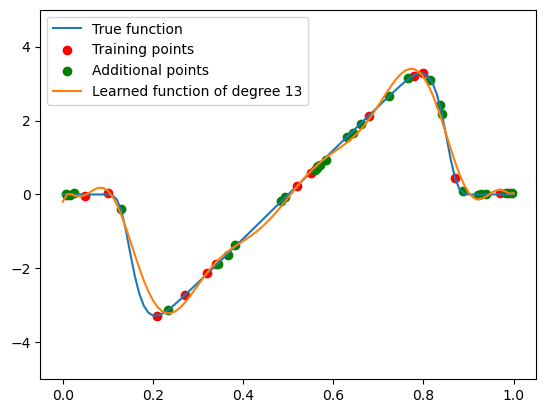

In [173]:
X_plot = np.linspace(0, 1, 101)
fig3_2, ax3_2 = plt.subplots()

ax3_2.plot(X_plot, true_function(X_plot), label='True function')

ax3_2.scatter(X_eval, y_eval, c='r', label='Training points')
if added_samples > 0:
    ax3_2.scatter(X_added, y_added, c='g', label='Additional points')
ax3_2.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_2.set_ylim(-5, 5)
ax3_2.legend()
plt.show()

### Exercise 4.3
To evaluate the models produced, one commonly uses cross-validation. 

__Task__: Implement K-fold cross validation and find your best model with RMSE as your metric. Plot the best model. Use only the initial data, without additional samples. Implement yourself or use an existing tool, e.g.  <a href="http://scikit-learn.org/stable/modules/cross_validation.html" title="Scikit-Learn Cross Validation">Scikit-Learn</a>.

__Tip__: Ensure nearby points don't go in the same batch, so that every model has data from the entire space.

__Question__:
What performance (RMSE, average on the test sets) did your top-performing model yield for K = 5?

__Answer__:

degree vs RMSE:
 degree  1: 1.6911
 degree  2: 1.7730
 degree  3: 0.9197
 degree  4: 1.0892
 degree  5: 0.9306
 degree  6: 1.0776
 degree  7: 1.2524
 degree  8: 2.2992
 degree  9: 1.0192
 degree 10: 5.7550
 degree 11: 2.9110
 degree 12: 2.6842
 degree 13: 3.2750
 degree 14: 4.5481
 degree 15: 6.4020
Best degree 3 with RMSE 0.9197


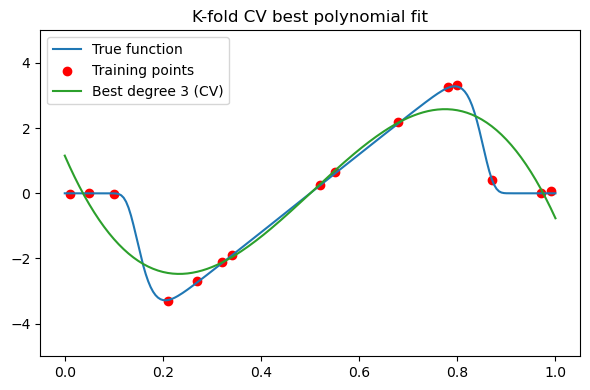

In [162]:
# K-fold cross validation to select the best polynomial degree
k = 5
degrees = range(1, 16)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52,
                   0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
y_eval = noisy_function(X_eval)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

best_rmse = float('inf')
best_degree = None
cv_results = []
indices = np.arange(X_eval.shape[0])

for degree in degrees:
    fold_rmses = []
    for fold in range(k):
        val_idx = indices[fold::k]
        train_idx = np.setdiff1d(indices, val_idx)
        pr = PolynomialRegression(degree)
        pr.fit_MLE(X_eval[train_idx], y_eval[train_idx])
        preds = pr.predict(X_eval[val_idx])
        fold_rmses.append(rmse(y_eval[val_idx], preds))
    mean_rmse = np.mean(fold_rmses)
    cv_results.append((degree, mean_rmse))
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_degree = degree

print('degree vs RMSE:')
for degree, rmse_val in cv_results:
    print(f' degree {degree:2d}: {rmse_val:.4f}')
print(f'Best degree {best_degree} with RMSE {best_rmse:.4f}')

# Plot the best model learned with all data
pr_best = PolynomialRegression(best_degree)
pr_best.fit_MLE(X_eval, y_eval)
X_plot = np.linspace(-0.0, 1.0, 201)
fig4_3, ax4_3 = plt.subplots(figsize=(6, 4))
ax4_3.plot(X_plot, true_function(X_plot), label='True function')
ax4_3.scatter(X_eval, y_eval, c='r', label='Training points')
ax4_3.plot(X_plot, pr_best.predict(X_plot),
            label=f'Best degree {best_degree} (CV)', color='tab:green')
ax4_3.set_ylim(-5, 5)
ax4_3.legend()
ax4_3.set_title('K-fold CV best polynomial fit')
plt.tight_layout()
plt.show()


### Exercise 4.4 (Optional)

You might have noticed that when you set the polynomial degree higher than the number of data points, the polynomial does not fit the data perfectly. However, this is what you would expect as the linear system of equations is overconstrained (test this by, e.g., using a polynomial of degree 100):

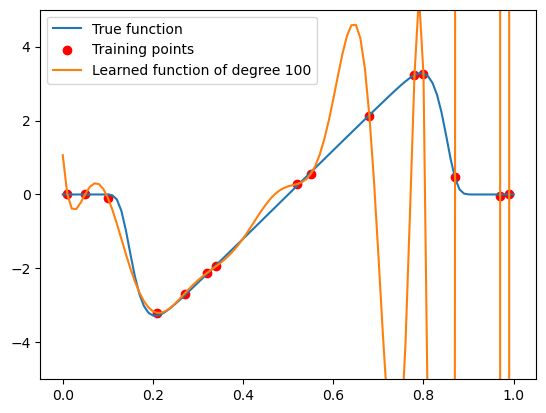

In [163]:
polynomial_degree = 100

pr = PolynomialRegression(polynomial_degree)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52, 0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
pr.fit_MLE(X_eval, y_eval)

# Plotting
X_plot = np.linspace(-0.0, 1.0, 101)
fig3_3, ax3_3 = plt.subplots()
ax3_3.plot(X_plot, true_function(X_plot), label='True function')

ax3_3.scatter(X_eval, y_eval, c='r', label='Training points')
ax3_3.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax3_3.set_ylim(-5, 5)
ax3_3.legend()
plt.show()

Below is the closed-form MLE solution which you (probably) used to solve above question. However, note that our original problem is a least squares problem:

$$
   \min_{\mathbf{\beta}} || \mathbf{y} - \theta\beta  ||^{2}
$$

You might have noticed that for high polynomial degrees, the polynomial does not fit the datapoints perfectly - even though this is what you would expect. This is because using the closed-form solution is numerically unstable. In fact, we are better off using NumPy's `numpy.linalg.lstsq` which takes the design matrix $\theta$ and the vector $\mathbf{y}$ as input and returns a $\beta$ that satisfies above formula. `numpy.linalg.lstsq` uses an iterative approach for solving the problem and is much more stable.

**Task:** Change the `fit_MLE` function to use `numpy.linalg.lstsq` and see how the solution gets more stable by using polynomials of high degrees. Note that `numpy.linalg.lstsq` returns a tuple from which you need the first element, also you might want to set `rcond=None` when calling `numpy.linalg.lstsq` to suppress warnings.

After changing the `fit_MLE` function, the polynomial of degree 100 should fit all points perfectly.